Установим необходимые библиотеки

In [1]:
!pip install pycocotools
!pip install -q datasets transformers evaluate timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 20.4 MB/s eta 0:00:00


In [215]:
!pip install mplsoccer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 1.6 MB/s eta 0:00:00a 0:00:01


In [74]:
from pathlib import Path
import shutil

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import albumentations as A
import json
import cv2
import yaml
import pycocotools
import gc
import datasets
import seaborn as sns
import holidays
from copy import deepcopy

from PIL import Image
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from albumentations.pytorch.transforms import ToTensorV2
from datasets import Dataset as TDataset

from tqdm import tqdm

from IPython.display import clear_output
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics.detection.mean_ap import MeanAveragePrecision
# from mplsoccer import Pitch

from scipy.ndimage import gaussian_filter
from transformers import DetrForObjectDetection, DetrImageProcessor, Trainer, TrainingArguments, DetrConfig
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


comp_root = Path('/kaggle/input/nfl-health-and-safety-helmet-assignment')
work_root = Path('/kaggle/working')
data_root = Path('/kaggle/input/nfl-big-data-bowl-2022')

Будем работать с данными с [соревнования](https://www.kaggle.com/competitions/nfl-big-data-bowl-2022/overview) в Kaggle. Для начала проанализируем имеющиеся данные

In [3]:
df_games = pd.read_csv(data_root / 'games.csv')
df_games.head()

gameId  season  week    gameDate gameTimeEastern homeTeamAbbr  \
0  2018090600    2018     1  09/06/2018        20:20:00          PHI   
1  2018090900    2018     1  09/09/2018        13:00:00          BAL   
2  2018090901    2018     1  09/09/2018        13:00:00          CLE   
3  2018090902    2018     1  09/09/2018        13:00:00          IND   
4  2018090903    2018     1  09/09/2018        13:00:00          MIA   

  visitorTeamAbbr  
0             ATL  
1             BUF  
2             PIT  
3             CIN  
4             TEN

Работаем с табличными данными о прошедших играх предыдущих сезонов

In [4]:
df_games['month'] = df_games.gameDate.str.split('/').apply(lambda x : int(x[0]))
df_games['day'] = df_games.gameDate.str.split('/').apply(lambda x : int(x[1]))
df_games['year'] = df_games.gameDate.str.split('/').apply(lambda x : int(x[2]))
df_games['hour'] = df_games.gameTimeEastern.str.split(':').apply(lambda x : int(x[0]))
df_games['minute'] = df_games.gameTimeEastern.str.split(':').apply(lambda x : int(x[1]))
df_games['second'] = df_games.gameTimeEastern.str.split(':').apply(lambda x : int(x[2]))
df_games['date'] = pd.to_datetime(df_games[['day', 'month', 'year', 'hour', 'minute', 'second']])
df_games

gameId  season  week    gameDate gameTimeEastern homeTeamAbbr  \
0    2018090600    2018     1  09/06/2018        20:20:00          PHI   
1    2018090900    2018     1  09/09/2018        13:00:00          BAL   
2    2018090901    2018     1  09/09/2018        13:00:00          CLE   
3    2018090902    2018     1  09/09/2018        13:00:00          IND   
4    2018090903    2018     1  09/09/2018        13:00:00          MIA   
..          ...     ...   ...         ...             ...          ...   
759  2021010311    2020    17  01/03/2021        16:25:00          DEN   
760  2021010312    2020    17  01/03/2021        16:25:00          HOU   
761  2021010313    2020    17  01/03/2021        16:25:00          IND   
762  2021010314    2020    17  01/03/2021        16:25:00           LA   
763  2021010315    2020    17  01/03/2021        16:25:00           SF   

    visitorTeamAbbr  month  day  year  hour  minute  second  \
0               ATL      9    6  2018    20      20       0   
1               BUF      9    9  2018    13       0       0   
2               PIT      9    9  2018    13       0       0   
3               CIN      9    9  2018    13       0       0   
4               TEN      9    9  2018    13       0       0   
..              ...    ...  ...   ...   ...     ...     ...   
759              LV      1    3  2021    16      25       0   
760             TEN      1    3  2021    16      25       0   
761             JAX      1    3  2021    16      25       0   
762             ARI      1    3  2021    16      25       0   
763             SEA      1    3  2021    16      25       0   

                   date  
0   2018-09-06 20:20:00  
1   2018-09-09 13:00:00  
2   2018-09-09 13:00:00  
3   2018-09-09 13:00:00  
4   2018-09-09 13:00:00  
..                  ...  
759 2021-01-03 16:25:00  
760 2021-01-03 16:25:00  
761 2021-01-03 16:25:00  
762 2021-01-03 16:25:00  
763 2021-01-03 16:25:00  

[764 rows x 14 columns]

Посмотрим на распределение игр по дням недели

Text(0.5, 1.0, 'Распред. игр по дням')

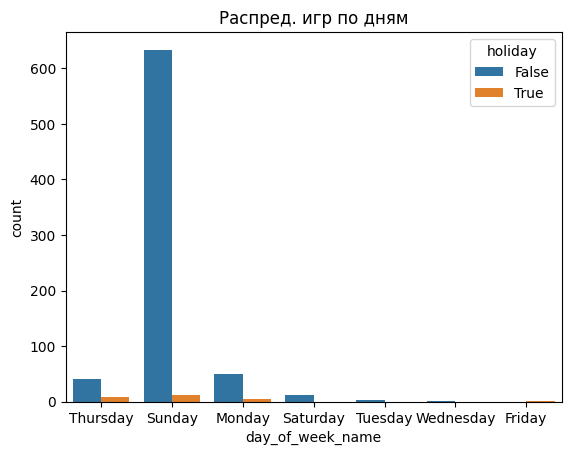

In [5]:
df_games['day_of_week_name'] = df_games.date.dt.day_name()
df_games['holiday'] = df_games.date.dt.date.apply(lambda x : x in holidays.US())
ax = sns.countplot(df_games, x='day_of_week_name', hue='holiday')
plt.title('Распред. игр по дням')

Посмотрим на распределение игр по часам дня

Text(0.5, 1.0, 'Распред. игр по часам')

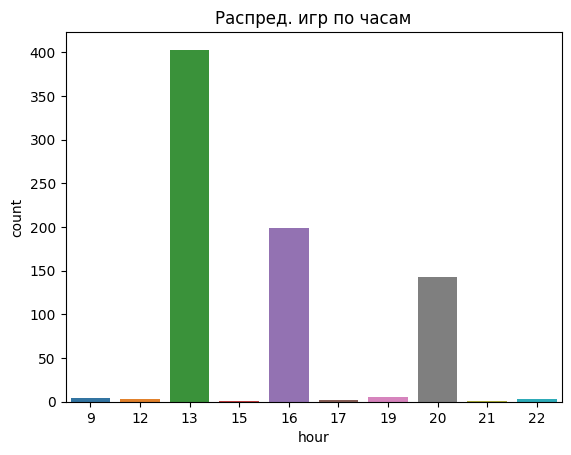

In [6]:
ax = sns.countplot(df_games, x='hour')
plt.title('Распред. игр по часам')

Text(0.5, 1.0, 'Распред. игр по дням')

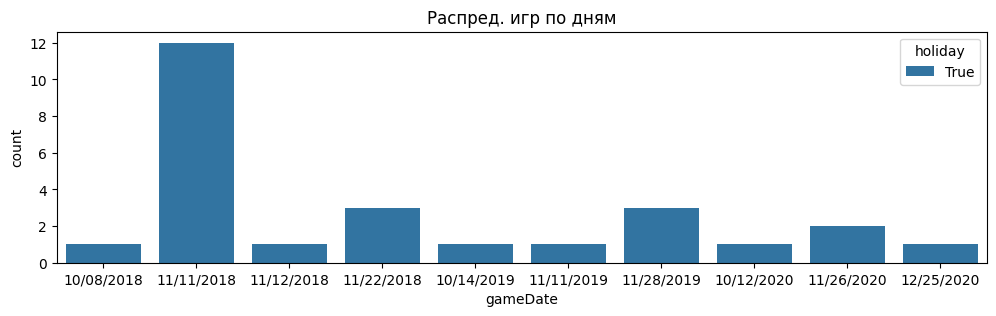

In [7]:
plt.figure(figsize=(12, 3))
ax = sns.countplot(df_games[df_games.holiday], x='gameDate', hue='holiday')
plt.title('Распред. игр по дням')

Text(0.5, 1.0, 'Распред. игр по праздничным дням')

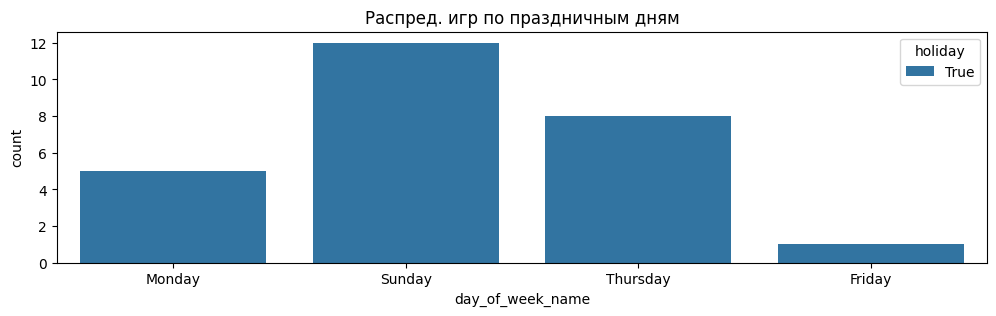

In [8]:
plt.figure(figsize=(12, 3))
ax = sns.countplot(df_games[df_games.holiday], x='day_of_week_name', hue='holiday')
plt.title('Распред. игр по праздничным дням')

Игры обычно проводятся по воскресеньям. В праздничные дни распределение более равномерное между разынми днями недели. Игры проводятся в основном в 13, 16 и 20 часов дня

In [12]:
df_plays = pd.read_csv(data_root / 'plays.csv')
df_plays.head()

gameId  playId                                    playDescription  \
0  2018090600      37  J.Elliott kicks 65 yards from PHI 35 to end zo...   
1  2018090600     366  (9:20) C.Johnston punts 56 yards to ATL 36, Ce...   
2  2018090600     658  (5:03) M.Bryant 21 yard field goal is GOOD, Ce...   
3  2018090600     677  M.Bosher kicks 64 yards from ATL 35 to PHI 1. ...   
4  2018090600     872  (:33) C.Johnston punts 65 yards to end zone, C...   

   quarter  down  yardsToGo possessionTeam specialTeamsPlayType  \
0        1     0          0            PHI              Kickoff   
1        1     4          4            PHI                 Punt   
2        1     4          3            ATL           Field Goal   
3        1     0          0            ATL              Kickoff   
4        1     4         18            PHI                 Punt   

  specialTeamsResult  kickerId  ... penaltyCodes  penaltyJerseyNumbers  \
0          Touchback   44966.0  ...          NaN                   NaN   
1             Return   45603.0  ...         UNSd                PHI 18   
2  Kick Attempt Good   27091.0  ...          NaN                   NaN   
3             Return   37267.0  ...          NaN                   NaN   
4          Touchback   45603.0  ...          NaN                   NaN   

  penaltyYards  preSnapHomeScore preSnapVisitorScore passResult kickLength  \
0          NaN                 0                   0        NaN       66.0   
1        -15.0                 0                   0        NaN       56.0   
2          NaN                 0                   0        NaN       21.0   
3          NaN                 0                   3        NaN       64.0   
4          NaN                 0                   3        NaN       65.0   

   kickReturnYardage  playResult  absoluteYardlineNumber  
0                NaN          40                      45  
1                5.0          36                      18  
2                NaN           0                      13  
3               30.0          34                      75  
4                NaN          45                      45  

[5 rows x 25 columns]

In [32]:
df_players = pd.read_csv(data_root / 'players.csv')
df_players.head()

nflId height  weight   birthDate       collegeName Position  \
0  42901    6-1     208  1992-07-25     James Madison       SS   
1  43501    6-0     220  1994-08-11  Central Michigan       FS   
2  43534    6-0     205  1993-06-02          Illinois       SS   
3  43535    6-1     235  1992-12-22            Temple      MLB   
4  44174    6-1     236  1993-02-22        Texas Tech      ILB   

         displayName  
0       Dean Marlowe  
1      Kavon Frazier  
2  Clayton Fejedelem  
3   Tyler Matakevich  
4       Sam Eguavoen

In [27]:
df_plays.passResult.unique()

array([nan, 'I', 'C', 'IN', 'S'], dtype=object)

In [28]:
df_plays.fillna(0, inplace=True)

In [31]:
df_plays[['kickerId', 'kickLength']]

kickerId  kickLength
0       44966.0        66.0
1       45603.0        56.0
2       27091.0        21.0
3       37267.0        64.0
4       45603.0        65.0
...         ...         ...
19974   41175.0        75.0
19975   41175.0         0.0
19976   41175.0        75.0
19977   47590.0         0.0
19978   47893.0         9.0

[19979 rows x 2 columns]

In [71]:
df_kick_length_info = df_kick_length_info[df_kick_length_info.height.str.split('-').apply(lambda x : len(x)) == 2]

In [79]:
df_kick_length_info = df_plays[['kickerId', 'kickLength']].merge(df_players, left_on='kickerId', right_on='nflId')
df_kick_length_info = df_kick_length_info[df_kick_length_info.height.str.split('-').apply(lambda x : len(x)) == 2]
df_kick_length_info['weight'] = df_kick_length_info['weight'] * 0.453592
df_kick_length_info['height'] = df_kick_length_info.height.str.split('-').apply(lambda x : int(x[0]) * 30.48 + int(x[1]) * 2.54)
df_kick_length_info['bmi'] = df_kick_length_info['weight'] / (df_kick_length_info['height']/100) ** 2 
df_kick_length_info.head()

kickerId  kickLength  nflId  height     weight   birthDate collegeName  \
0   44966.0        66.0  44966  175.26  75.749864  1995-01-21     Memphis   
1   45603.0        56.0  45603  180.34  87.996848  1992-02-24  Ohio State   
2   27091.0        21.0  27091  175.26  92.079176  05/29/1975      Baylor   
4   45603.0        65.0  45603  180.34  87.996848  1992-02-24  Ohio State   
6   44966.0        26.0  44966  175.26  75.749864  1995-01-21     Memphis   

  Position       displayName        bmi  
0        K      Jake Elliott  24.661316  
1        P  Cameron Johnston  27.057208  
2        K       Matt Bryant  29.977527  
4        P  Cameron Johnston  27.057208  
6        K      Jake Elliott  24.661316

Посмотрим на зависимость длины удара от физических параметров игрока (индекс массы тела)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='bmi', ylabel='kickLength'>

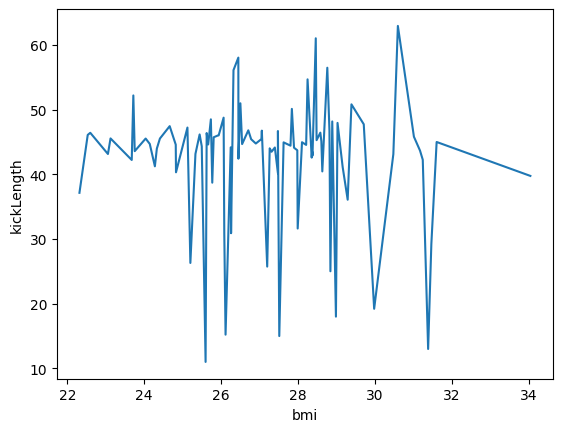

In [114]:
sns.lineplot(df_kick_length_info.groupby(['bmi']).kickLength.mean().reset_index(), x='bmi', y='kickLength')

Зависимость выглядит довольно стационарной

<Axes: xlabel='weight', ylabel='height'>

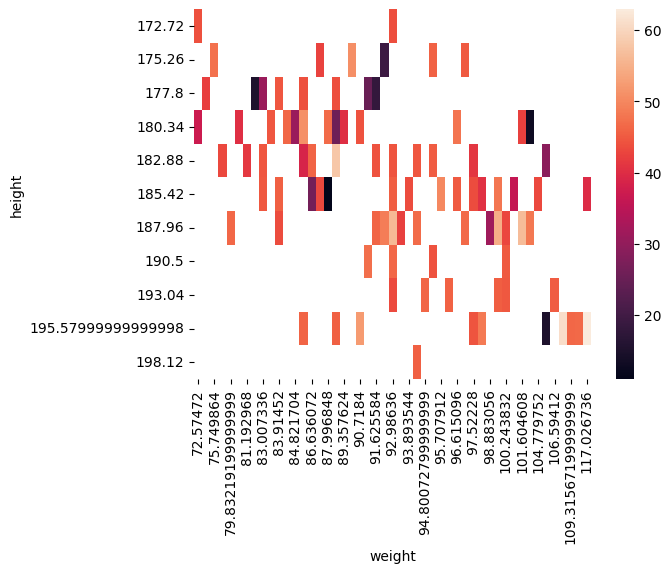

In [111]:
df_plot = df_kick_length_info.groupby(['weight', 'height']).kickLength.mean().reset_index()
sns.heatmap(df_plot.pivot(index='height', columns='weight', values='kickLength'))

Посмотрим на зависимость результата игры от предыдущих значений счета. История наносится на график красной, если команда победила и синей, если проиграла.

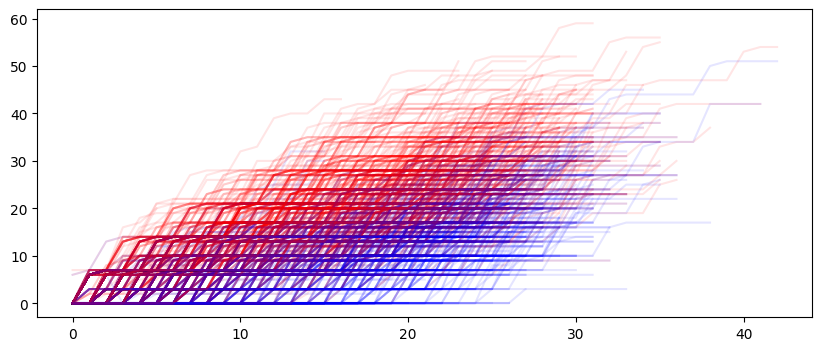

In [137]:
home_scores = df_plays.groupby('gameId').preSnapHomeScore.apply(lambda x : [e for e in x])
visitor_scores = df_plays.groupby('gameId').preSnapVisitorScore.apply(lambda x : [e for e in x])
plt.figure(figsize=(10, 4))
for i in range(len(home_scores)):
    if home_scores.iloc[i][-1] > visitor_scores.iloc[i][-1]:
        plt.plot(np.arange(len(home_scores.iloc[i])), home_scores.iloc[i], color='red', alpha=0.1)
        plt.plot(np.arange(len(visitor_scores.iloc[i])), visitor_scores.iloc[i], color='blue', alpha=0.1)
    else:
        plt.plot(np.arange(len(home_scores.iloc[i])), home_scores.iloc[i], color='blue', alpha=0.1)
        plt.plot(np.arange(len(visitor_scores.iloc[i])), visitor_scores.iloc[i], color='red', alpha=0.1)

Видим, что красные линии идут почти строго над синими. Значит, команда, ведущая по ходу игры, вероятнее всего победит, то есть камбэки не очень вероятны

In [183]:
home_final_scores = df_plays.groupby('gameId').preSnapHomeScore.apply(lambda x : [e for e in x][-1])
visitor_final_scores = df_plays.groupby('gameId').preSnapVisitorScore.apply(lambda x : [e for e in x][-1])
final_scores = pd.DataFrame(home_final_scores).merge(visitor_final_scores, on='gameId')
final_scores['homeWinner'] = final_scores.preSnapHomeScore > final_scores.preSnapVisitorScore
final_scores = final_scores.merge(df_games, on='gameId')
final_scores['winner'] = final_scores.homeTeamAbbr.where(final_scores.homeWinner, final_scores.visitorTeamAbbr)
final_scores['loser'] = final_scores.visitorTeamAbbr.where(final_scores.homeWinner, final_scores.homeTeamAbbr)
final_scores.head()

gameId  preSnapHomeScore  preSnapVisitorScore  homeWinner  season  \
0  2018090600                18                   12        True    2018   
1  2018090900                47                    3        True    2018   
2  2018090901                21                   21       False    2018   
3  2018090902                23                   34       False    2018   
4  2018090903                27                   20        True    2018   

   week    gameDate gameTimeEastern homeTeamAbbr visitorTeamAbbr  ...  day  \
0     1  09/06/2018        20:20:00          PHI             ATL  ...    6   
1     1  09/09/2018        13:00:00          BAL             BUF  ...    9   
2     1  09/09/2018        13:00:00          CLE             PIT  ...    9   
3     1  09/09/2018        13:00:00          IND             CIN  ...    9   
4     1  09/09/2018        13:00:00          MIA             TEN  ...    9   

   year  hour  minute  second                date day_of_week_name holiday  \
0  2018    20      20       0 2018-09-06 20:20:00         Thursday   False   
1  2018    13       0       0 2018-09-09 13:00:00           Sunday   False   
2  2018    13       0       0 2018-09-09 13:00:00           Sunday   False   
3  2018    13       0       0 2018-09-09 13:00:00           Sunday   False   
4  2018    13       0       0 2018-09-09 13:00:00           Sunday   False   

   winner loser  
0     PHI   ATL  
1     BAL   BUF  
2     PIT   CLE  
3     CIN   IND  
4     MIA   TEN  

[5 rows x 21 columns]

Посмотрим на список самых успешных команд

In [189]:
win = final_scores.groupby('winner').loser.count()
win.name = 'wins'
lose = final_scores.groupby('loser').winner.count()
lose.name = 'losses'
wl = pd.DataFrame(win).merge(lose, left_index=True, right_index=True)
wl.sort_values(by=['wins', 'losses'], ascending=[False, True])

wins  losses
winner              
KC        37      10
NO        37      11
BAL       35      13
SEA       33      14
LA        33      15
GB        31      17
PIT       30      18
NE        29      19
BUF       28      20
TEN       28      20
CHI       27      20
HOU       27      21
IND       27      21
MIN       26      20
CLE       25      23
TB        25      23
LAC       24      23
SF        23      24
PHI       22      26
MIA       21      27
DAL       20      28
ATL       19      29
ARI       18      30
CAR       18      30
NYG       17      31
WAS       17      31
DEN       16      31
DET       16      32
CIN       13      35
JAX       12      36
NYJ       12      36
LV         9       7
OAK        9      23

In [190]:
df_tracking = pd.read_csv(data_root / 'tracking2020.csv')

In [250]:
import matplotlib.patches as patches
from matplotlib.patches import Arc
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

# Change size of the figure
plt.rcParams['figure.figsize'] = [24, 16]
def drawPitch(width, height, color="w"):
    fig = plt.figure()
    ax = plt.axes(xlim=(-10, width + 30), ylim=(-15, height + 5))
    plt.axis('off')

    # Grass around pitch
    rect = patches.Rectangle((-10, -5), width + 40, height + 10, linewidth=1, facecolor='#3f995b', capstyle='round')
    ax.add_patch(rect)
    ###################

    # Pitch boundaries
    rect = plt.Rectangle((0, 0), width + 20, height, ec=color, fc="None", lw=2)
    ax.add_patch(rect)
    ###################

    # vertical lines - every 5 yards
    for i in range(21):
        plt.plot([10 + 5 * i, 10 + 5 * i], [0, height], c="w", lw=2)
    ###################
        
    # distance markers - every 10 yards
    for yards in range(10, width, 10):
        yards_text = yards if yards <= width / 2 else width - yards
        # top markers
        plt.text(10 + yards - 2, height - 7.5, yards_text, size=15, c="w", weight="bold")
        # botoom markers
        plt.text(10 + yards - 2, 7.5, yards_text, size=15, c="w", weight="bold", rotation=180)
    ###################

    # yards markers - every yard
    # bottom markers
    for x in range(20):
        for j in range(1, 5):
            plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [1, 3], color="w", lw=2)

    # top markers
    for x in range(20):
        for j in range(1, 5):
            plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [height - 1, height - 3], color="w", lw=2)

    # middle bottom markers
    y = (height - 18.5) / 2
    for x in range(20):
        for j in range(1, 5):
            plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [y, y + 2], color="w", lw=2)

    # middle top markers
    for x in range(20):
        for j in range(1, 5):
            plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [height - y, height - y - 2], color="w", lw=2)
    ###################

    # draw home end zone
    plt.text(2.5, (height - 15) / 2, "HOME", size=30, c="w", weight="bold", rotation=90)
    rect = plt.Rectangle((0, 0), 10, height, ec=color, fc="#0064dc", lw=2)
    ax.add_patch(rect)

    # draw away end zone    
    plt.text(111, (height - 15) / 2, "AWAY", size=30, c="w", weight="bold", rotation=-90)
    rect = plt.Rectangle((width + 10, 0), 10, height, ec=color, fc="#c80014", lw=2)
    ax.add_patch(rect)
    ###################
    
    # draw extra spot point
    # left
    y = (height - 3) / 2
    plt.plot([10 + 2, 10 + 2], [y, y + 3], c="w", lw=2)
    
    # right
    plt.plot([width + 10 - 2, width + 10 - 2], [y, y + 3], c="w", lw=2)
    ###################
    
    # draw goalpost
    goal_width = 6 # yards
    y = (height - goal_width) / 2
    # left
    plt.plot([0, 0], [y, y + goal_width], "-", c="y", lw=10, ms=20)
    # right
    plt.plot([width + 20, width + 20], [y, y + goal_width], "-", c="y", lw=10, ms=20)
    
    return fig, ax

Посмотрим на тепловую карту перемещений позиции квотербек

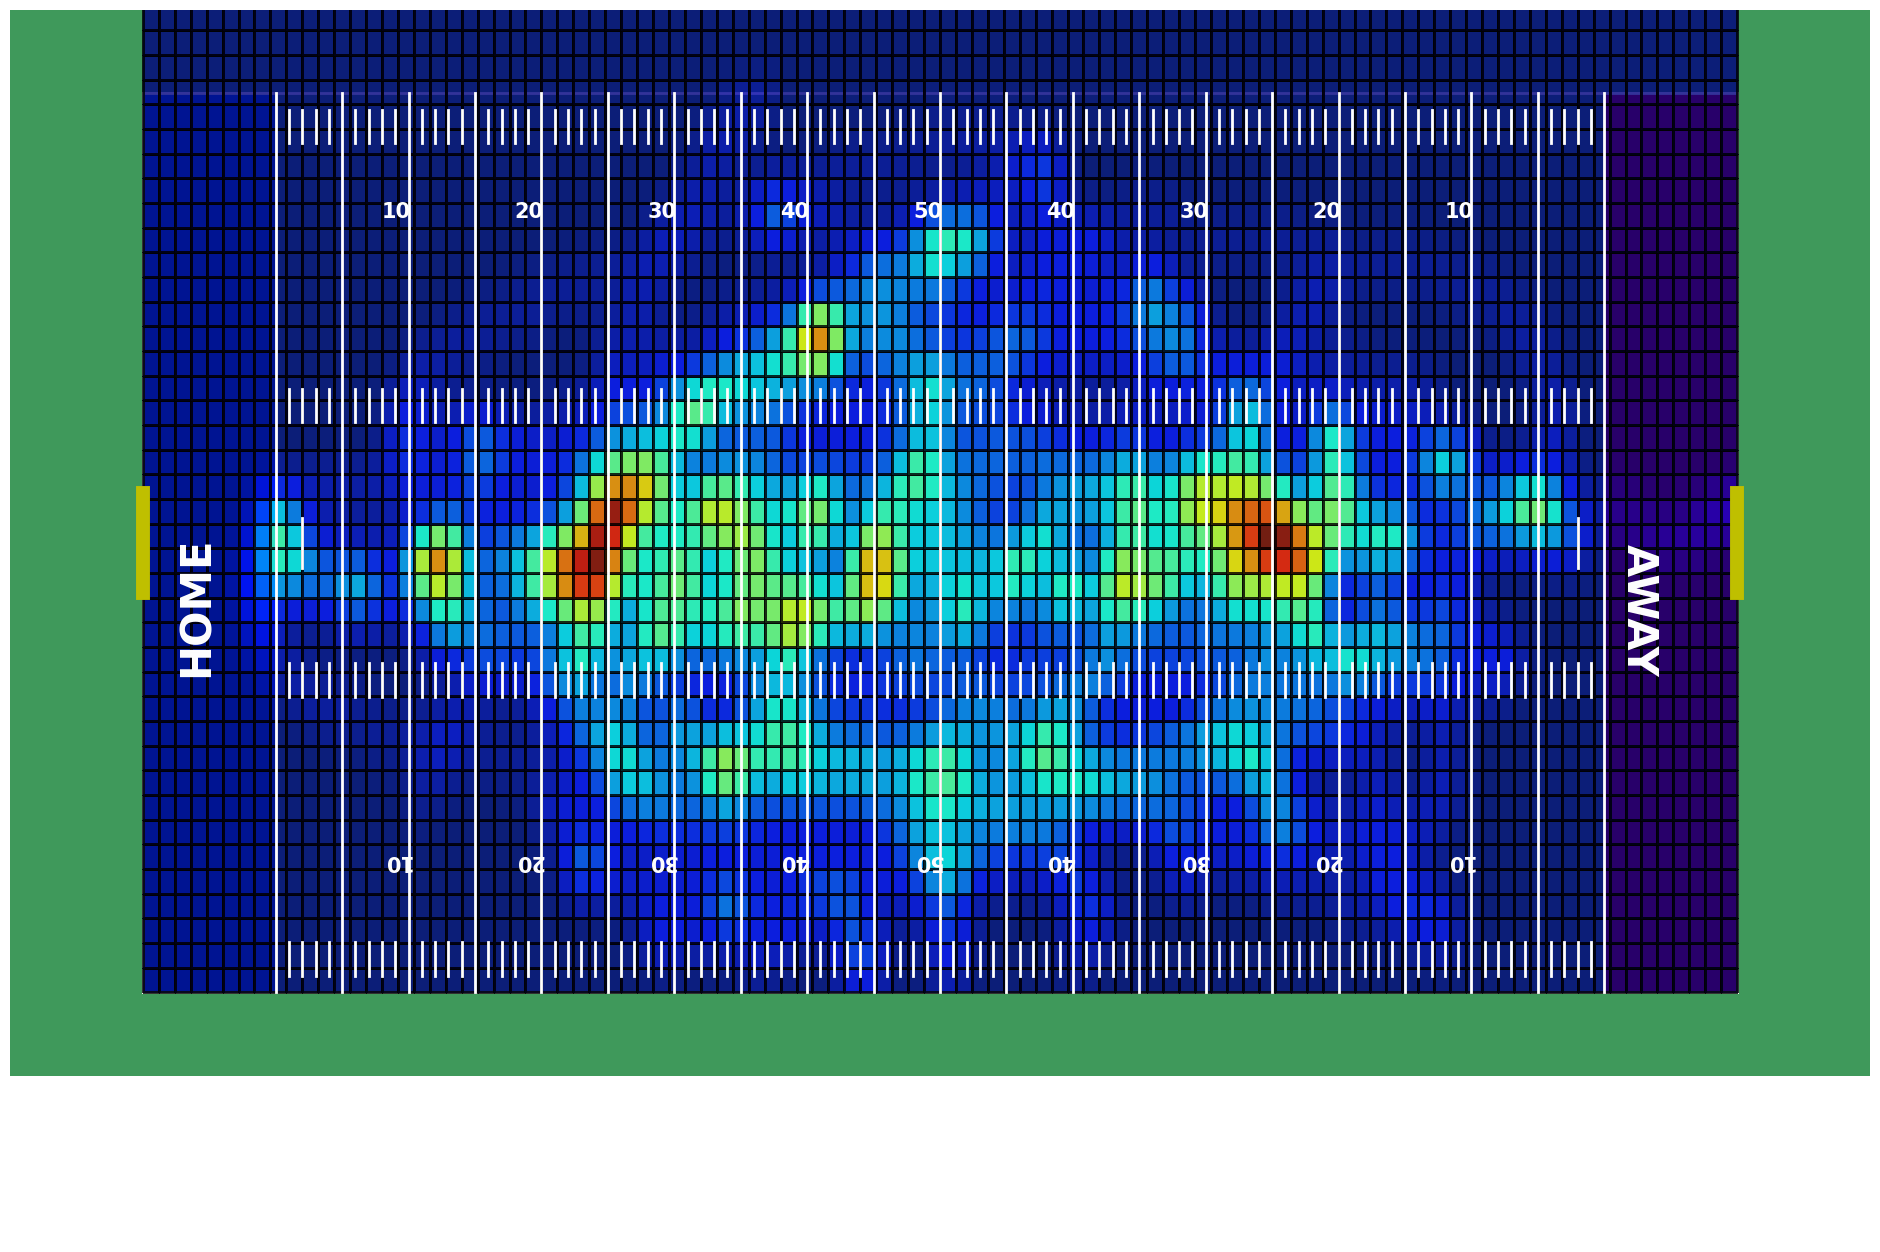

In [258]:
x = df_tracking[(df_tracking.position == 'QB')].groupby('team').x.apply(list)
y = df_tracking[(df_tracking.position == 'QB')].groupby('team').y.apply(list)

pitch = Pitch(line_alpha=0, goal_alpha=0)
fig, ax = drawPitch(100, 54)
stats = pitch.bin_statistic(x.home, y.home, bins=[100, 54])
stats['statistic'] = gaussian_filter(stats['statistic'], 1)
pitch.heatmap(stats, edgecolors='black', cmap='jet', ax=ax, alpha=0.8)
plt.show()

Перейдем к детекции шлемов на изображениях

Посмотрим на картинки из датасета

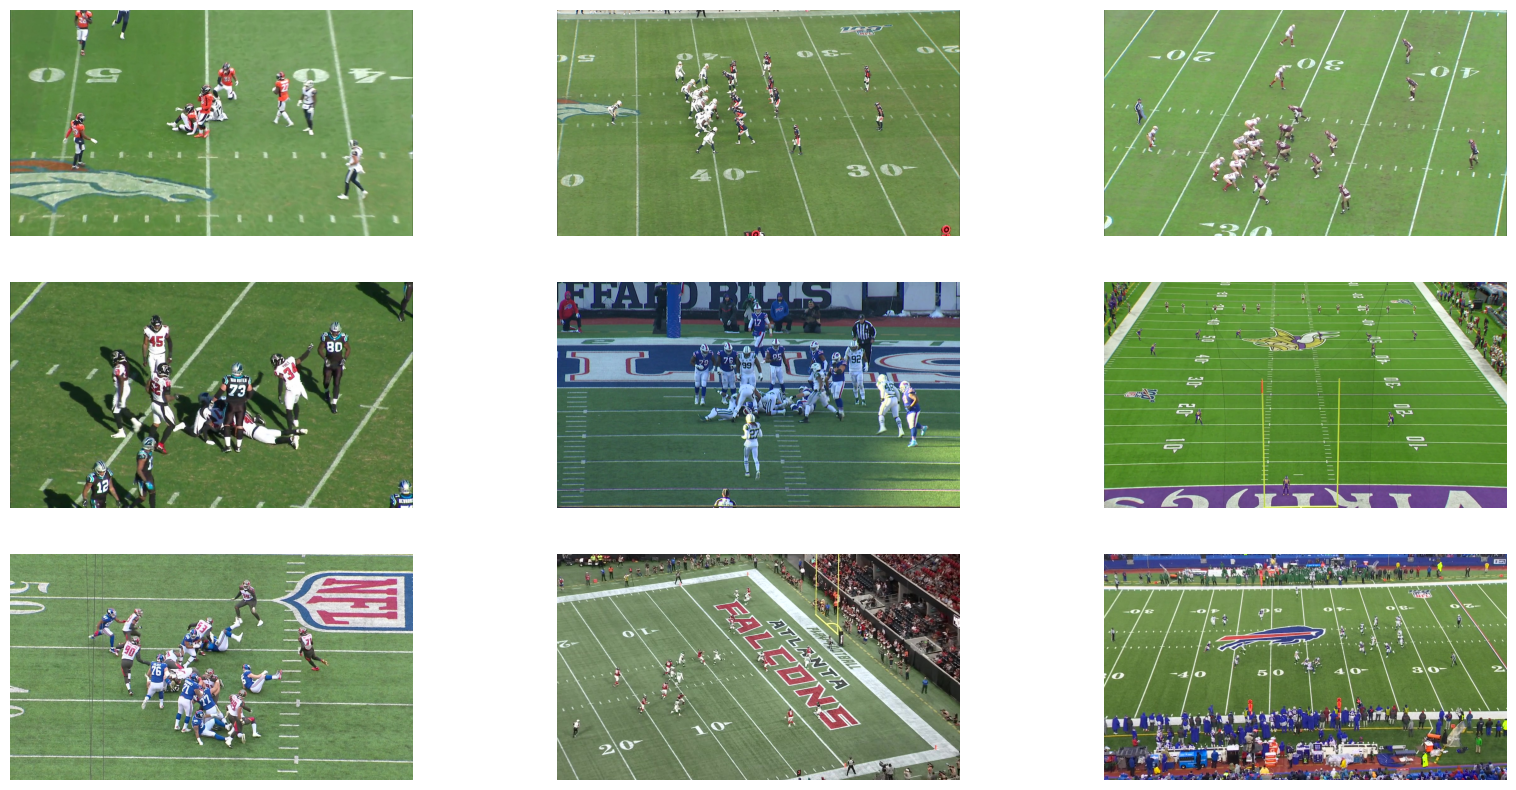

In [5]:
img_paths = [x for x in (comp_root / 'images').iterdir()]

plt.figure(figsize=(20, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(Image.open(img_paths[i]))
    plt.axis('off')

В датасете изображения поля сверху под разными ракурсами. Объекты, которые нужно детектировать, маленькие по сравнению с размерами картинки, и на одной картинке много объектов. Картинки большого разрешения: 1280x720

Загрузим аннотации

In [6]:
df_helmets = pd.read_csv(comp_root / 'image_labels.csv')
df_helmets.head()

image   label  left  width  top  height
0  57503_000116_Endzone_frame443.jpg  Helmet  1099     16  456      15
1  57503_000116_Endzone_frame443.jpg  Helmet  1117     15  478      16
2  57503_000116_Endzone_frame443.jpg  Helmet   828     16  511      15
3  57503_000116_Endzone_frame443.jpg  Helmet   746     16  519      16
4  57503_000116_Endzone_frame443.jpg  Helmet   678     17  554      17

Посмотрим на картинку с размеченными объектами. Для этого найдем картинку, на которой есть все лейблы

In [5]:
for i in range(len(df_helmets)):
    if df_helmets[df_helmets.image == df_helmets[df_helmets.index == i].image.tolist()[0]].label.unique().shape[0] == 5:
        print(i)
        break

6698


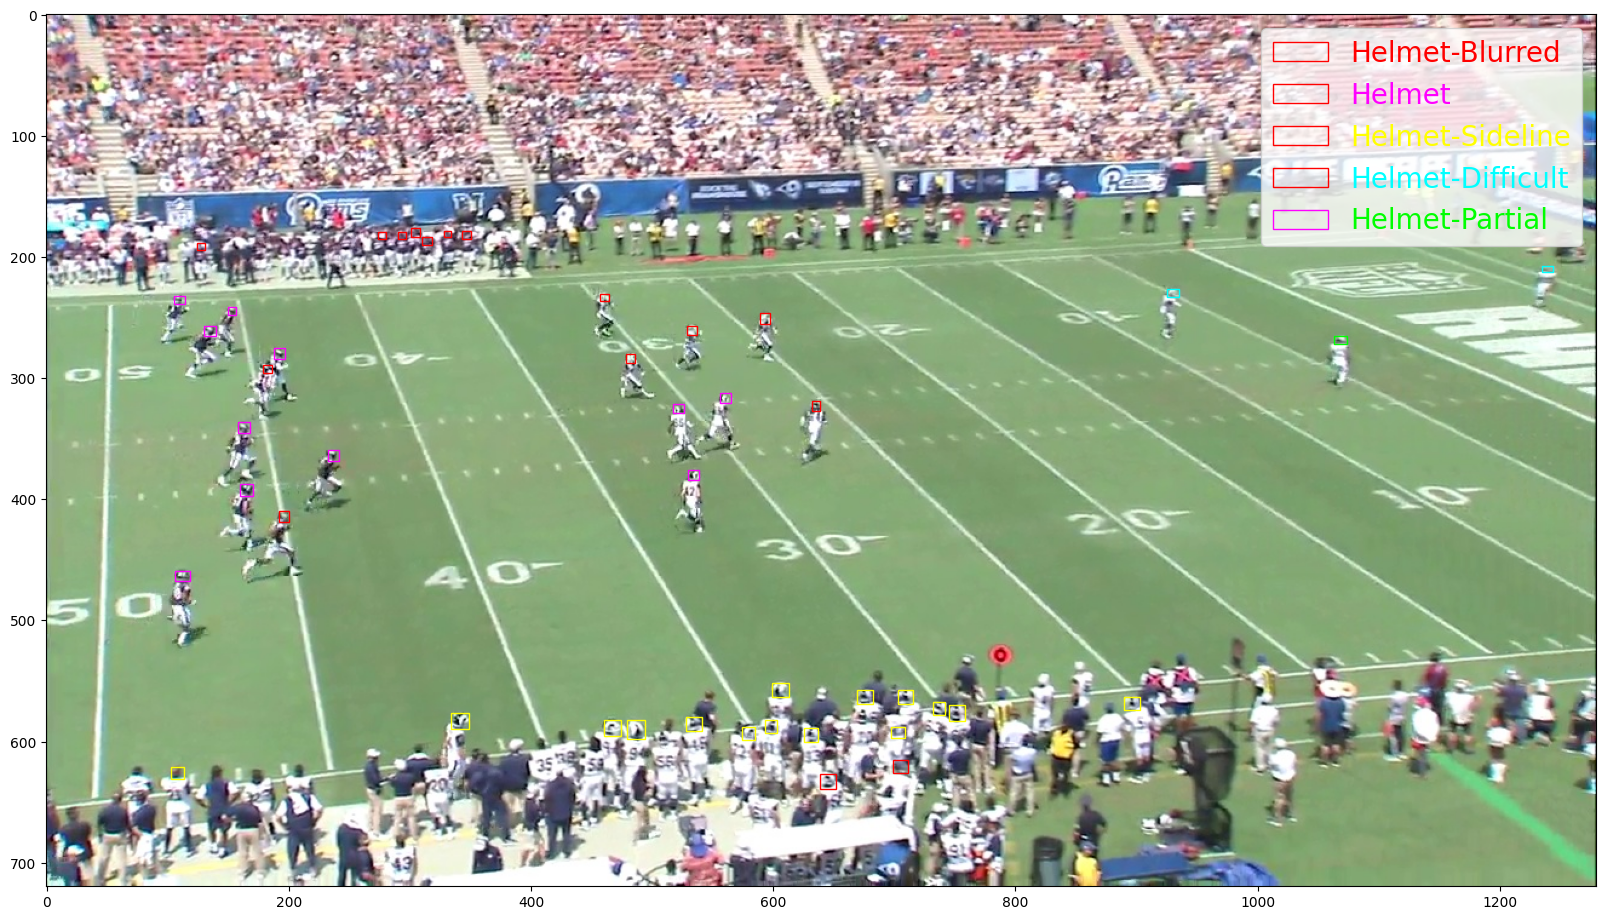

In [7]:
df_img = df_helmets[df_helmets.image == df_helmets[df_helmets.index == 6698].image.tolist()[0]]
img_file = df_img.image.tolist()[0]
d = dict(zip(df_img.label.unique(), [0, 1, 2, 3, 4]))
plt.figure(figsize=(20, 20))
plt.imshow(Image.open(comp_root / 'images' / img_file))

ax = plt.gca()
colors = ['red', 'magenta', 'yellow', 'cyan', 'lime']
dl = []
for i in df_img.index:
    label = df_img[df_img.index == i].label.values.item()
    left = df_img[df_img.index == i].left.values.item()
    width = df_img[df_img.index == i].width.values.item()
    height = df_img[df_img.index == i].height.values.item()
    top = df_img[df_img.index == i].top.values.item()
    rect = Rectangle((left, top), width, height, 
                     linewidth=1,edgecolor=colors[d[label]],
                     facecolor='none')
    ax.add_patch(rect)
# plt.axis('off')
plt.legend(labels=df_img.label.unique(), labelcolor=colors, fontsize=20)

In [6]:
df_helmets.groupby('label').count()

image    left   width     top  height
label                                                   
Helmet            129764  129764  129764  129764  129764
Helmet-Blurred     33544   33544   33544   33544   33544
Helmet-Difficult    6577    6577    6577    6577    6577
Helmet-Partial      8814    8814    8814    8814    8814
Helmet-Sideline    15037   15037   15037   15037   15037

Видно, что лейбл sideline есть только за пределами поля. На многих снимках его может попросту не быть, если на снимке только игровая зона, либо наоборот много семплов, когда бровка видна. Helmet -- самый популярный класс, blurred попадается реже, partial и difficult -- очень редкие классы.

Модели не работают с картинками большого разрешения, поэтому придется либо обучаться на кропах, либо сжимать картинку. Боксы и так небольшие, если сжимать картинку целиком, то они могут стать совсем не распознаваемыми. Поэтому я решил сначала попробовать обучать модель на кропах исходной картинки, а затем на инференсе проходиться по исходной картинке скользящим окном (SW_inference). Это увеличит время инференса, что может сказаться на real-time инференсе на видео, но по идее так качество должно получаться выше. Здесь есть еще и проблема связанная с тем, что на кропе часто могут быть объекты одного класса, например если это кроп в центре поля или где-то за бровкой. Также я обучал трансформер для детекции DETR уже без кропов.

Разделим изображения на обучающую и валидационную выборки

In [8]:
helmet_filenames_train, helmet_filenames_val = train_test_split(df_helmets.image.drop_duplicates().tolist(), test_size=0.2)

Создадим аннотации для обучающей и валидационной выборок

In [9]:
df_helmets = df_helmets.merge(pd.DataFrame(pd.Series(
    index=helmet_filenames_train+helmet_filenames_val,
    data=['train']*len(helmet_filenames_train)+['val']*len(helmet_filenames_val),
    name='split')).reset_index(), left_on='image', right_on='index').drop(columns='index')

le = LabelEncoder()
df_helmets['label_enc'] = le.fit_transform(df_helmets['label'])

annot_train = df_helmets[df_helmets.split == 'train']
annot_val = df_helmets[df_helmets.split == 'val']

assert len(annot_train) + len(annot_val) == len(df_helmets)

Создадим директории с данными

In [10]:
%cd /kaggle/working
%mkdir data_helmets
%cd data_helmets
%mkdir train
%mkdir val

/kaggle/working
/kaggle/working/data_helmets


In [11]:
for fname in tqdm(helmet_filenames_train):
    shutil.copy(comp_root / 'images' / fname, work_root / 'data_helmets' / 'train')

for fname in tqdm(helmet_filenames_val):
    shutil.copy(comp_root / 'images' / fname, work_root / 'data_helmets' / 'val')

100%|██████████| 1990/1990 [00:24<00:00, 80.56it/s]


In [13]:
train_dict = convert_to_coco(annot_train, work_root / 'data_helmets' / 'train' / 'annotations_coco.json')
val_dict = convert_to_coco(annot_val, work_root / 'data_helmets' / 'val' / 'annotations_coco.json')

NameError: name 'convert_to_coco' is not defined

In [ ]:
def batch_collator(batch):
    images = []
    labels = []

    for b in batch:
        images.append(b[0])
        labels.append({
            'image_id' : b[3],
            'annotations' : [{
                "category_id" : b[2][i],
                "bbox" : b[1][i],
                "area" : b[1][i][2] * b[1][i][3]
            } for i in range(len(b[1]))]
        })
    
    res = img_proc.preprocess(images, labels)
    images = []
    labels = []
    for i in range(len(res.pixel_values)):
        images.append(torch.tensor(res.pixel_values[i]))
        labels.append({
            'class_labels' : torch.tensor(res.labels[i]['class_labels']),
            'boxes' : torch.tensor(res.labels[i]['boxes'])
        })
    images = torch.stack(images)
    
    return {"pixel_values" : images, "labels" : labels}

In [13]:
# train_tdataset = TDataset.from_dict(train_dict)
# val_tdataset = TDataset.from_dict(val_dict)

Обучим трансформер для детекции DETR. Возьмемм реализацию из transformers

In [14]:
config = DetrConfig()
config.num_labels = 5
img_proc = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model0 = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection(config)
model.model.load_state_dict(model0.model.state_dict())

preprocessor_config.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [22]:
model.load_state_dict(torch.load('/kaggle/input/detectiontr/detr_weights(1).pt'))

<All keys matched successfully>

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [ ]:
for param in model.model.parameters():
    param.requires_grad = False

In [19]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# transforms = A.Compose([
#     A.Normalize(mean=MEAN, std=STD),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.2),
#     ToTensorV2()
# ], bbox_params=A.BboxParams(format='coco', label_fields=['labels']))

train_dataset = HelmetDataset(work_root / 'data_helmets' / 'train', annot_train, return_idx=True, ann_format='pascal_voc')
val_dataset = HelmetDataset(work_root / 'data_helmets' / 'val', annot_val, return_idx=True, ann_format='pascal_voc')

In [229]:
training_args = TrainingArguments(
    '/kaggle/working',
    remove_unused_columns=False,
    save_steps=48000,
    num_train_epochs=5,
    logging_steps=50
)
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=batch_collator
)

In [69]:
val_dataset[0][2]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [230]:
trainer.train()

TrainOutput(global_step=4975, training_loss=4.064297437811617, metrics={'train_runtime': 7361.2693, 'train_samples_per_second': 5.405, 'train_steps_per_second': 0.676, 'total_flos': 2.969554553176129e+19, 'train_loss': 4.064297437811617, 'epoch': 5.0})

In [288]:
for param in model.model.parameters():
    param.requires_grad = True

In [290]:
training_args = TrainingArguments(
    '/kaggle/working',
    remove_unused_columns=False,
    save_steps=48000,
    num_train_epochs=5,
    logging_steps=50
)
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=batch_collator
)

In [291]:
trainer.train()

TrainOutput(global_step=4975, training_loss=2.442842830485435, metrics={'train_runtime': 10459.7292, 'train_samples_per_second': 3.804, 'train_steps_per_second': 0.476, 'total_flos': 2.969554553176129e+19, 'train_loss': 2.442842830485435, 'epoch': 5.0})

In [292]:
torch.save(model.state_dict(), '/kaggle/working/detr_weights.pt')

Посмотрим на предсказания

In [89]:
def iou(a, b):
    intersection = max(0, min(a[2], b[2]) - max(a[0], b[0])) * max(0, min(a[3], b[3]) - max(a[1], b[1]))
    union = (a[2] - a[0]) * (a[3] - a[1]) + (b[2] - b[0]) * (b[3] - b[1]) - intersection
    
    return intersection / union

def non_max_suppression(output, iou_threshold=0.2):
    labels = output['labels']
    scores = output['scores']
    boxes = output['boxes']
    order = (-scores).argsort().tolist()
    
    res_idx = []
    while order:
        i = order.pop(0)
        res_idx.append(i)
        popped = 0
        order0 = deepcopy(order)
        for j, e in enumerate(order0):
            if iou(boxes[i], boxes[e]) > iou_threshold:
                order.pop(j-popped)
                popped+=1
    
    return {'labels' : labels[res_idx], 'scores' : scores[res_idx], 'boxes' : boxes[res_idx]}
    

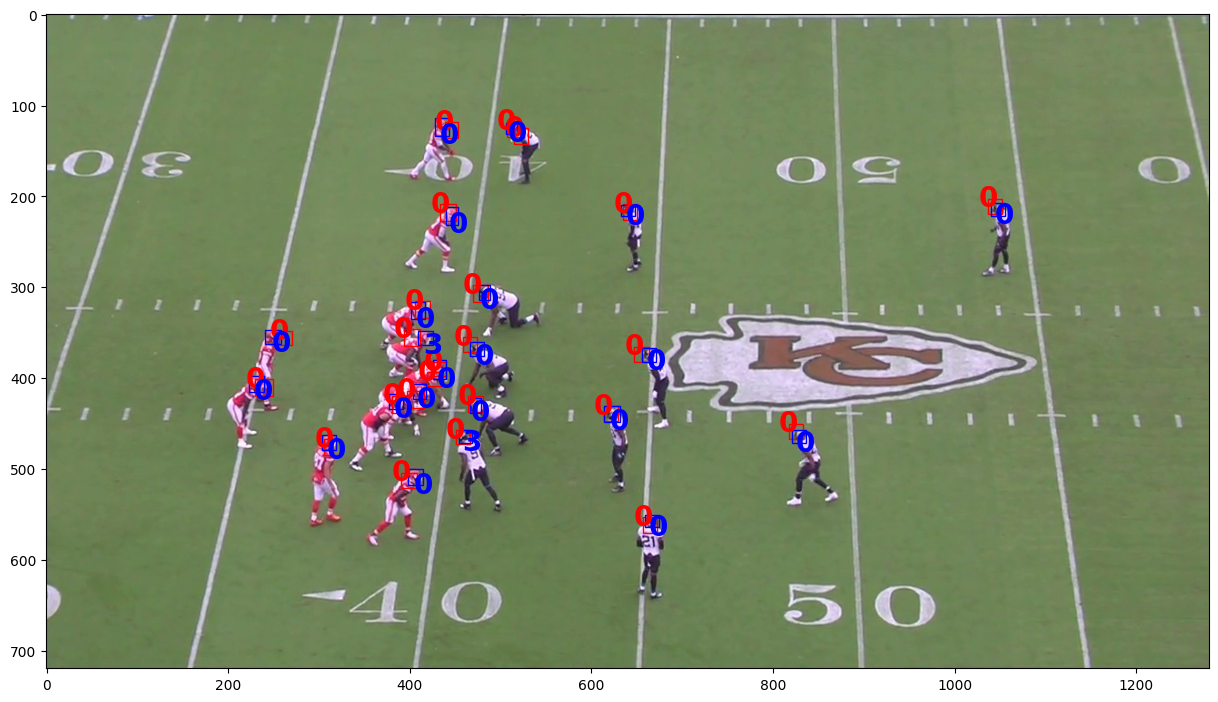

In [92]:
inference_img = val_dataset[228]
with torch.no_grad():
    output = model(torch.tensor(img_proc(inference_img[0]).pixel_values).to('cuda'))

plt.figure(figsize=(15, 10))
plt.imshow(inference_img[0] / 256)
height, width, _ = train_dataset[0][0].shape
output = img_proc.post_process_object_detection(output, threshold=0.5, target_sizes=([[height, width]]))[0]
output = non_max_suppression(output)

ax = plt.gca()
labels_pr = output['labels']
for i in range(len(labels_pr)):
    box = output['boxes'].cpu().squeeze()[i]
    rect = Rectangle(((box[0]), (box[1])), (box[2]-box[0]), (box[3]-box[1]),
                     linewidth=1, 
                     edgecolor='red',
                     facecolor='none')
    ax.annotate(labels_pr[i].item(), (box[0], box[1]), color='red', weight='bold', fontsize=20, ha='center', va='center')
    ax.add_patch(rect)
for i in range(len(inference_img[2])):
    box = inference_img[1][i]
    rect = Rectangle(((box[0]), (box[1])), (box[2]-box[0]), (box[3]-box[1]),
                     linewidth=1, 
                     edgecolor='blue',
                     facecolor='none')
    ax.annotate(inference_img[2][i], (box[2], box[3]), color='blue', weight='bold', fontsize=20, ha='center', va='center')
    ax.add_patch(rect)

Появились какие-то странные предсказания, боксы могут иметь небольшое пересечение реальным боксом. Тем не менее почти получается сделать предикт для всей картинки сразу и распознать все шлемы с конфиденсом выше, чем у SSD. Также модель предсказывает не только 0 класс (на картинке где видно сайдлайн, она предсказывает сайдлайн, например). На один шлем предсказывается много боксов, поэтому видимо надо делать NMS на инференсе

Создадим класс датасета

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Посчитаем mAP для DETR. Я думал что получится, чем у SSD, но почему-то скор низкий. Скорее всего из-за большого количества дублирующих боксов, надо делать NMS. 

In [93]:
def get_mAP_detr(dataset, model):
    metric = MeanAveragePrecision(iou_type="bbox")
    for i in tqdm(range(len(dataset))):
        image = dataset[i][0]
        gt_locs = dataset[i][1]
        gt_classes = dataset[i][2]
        gt_locs = torch.tensor(gt_locs).to(device)
        gt_classes = torch.tensor(gt_classes).to(device)
        pred = {}
        target = {}
        target['boxes'] = gt_locs.detach().cpu()
        target['labels'] = gt_classes.detach().cpu()
        
        a = torch.tensor(img_proc(torch.tensor(image).to(device)).pixel_values).to(device)
        with torch.no_grad():
            output = model(a)
        pred = img_proc.post_process_object_detection(output, threshold=0.35, target_sizes=([list(image.shape[:2])]))[0]
        pred = non_max_suppression(pred)
        pred = {'boxes' : pred['boxes'].cpu(),
                'labels' : pred['labels'].cpu(),
                'scores' : pred['scores'].cpu()}
        
        metric.update([pred], [target])
        if i % 50 == 0:
            clear_output()
            print(metric.compute())

    return metric.compute()

In [94]:
model = model.to(device)
get_mAP_detr(val_dataset, model)

 98%|█████████▊| 1951/1990 [51:05<06:28,  9.96s/it]

{'map': tensor(0.0269), 'map_50': tensor(0.0891), 'map_75': tensor(0.0063), 'map_small': tensor(0.0238), 'map_medium': tensor(0.0528), 'map_large': tensor(0.), 'mar_1': tensor(0.0043), 'mar_10': tensor(0.0327), 'mar_100': tensor(0.0454), 'mar_small': tensor(0.0418), 'mar_medium': tensor(0.0764), 'mar_large': tensor(0.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([0, 1, 2, 3, 4], dtype=torch.int32)}


100%|██████████| 1990/1990 [51:56<00:00,  1.57s/it]


{'map': tensor(0.0269),
 'map_50': tensor(0.0890),
 'map_75': tensor(0.0063),
 'map_small': tensor(0.0238),
 'map_medium': tensor(0.0527),
 'map_large': tensor(0.),
 'mar_1': tensor(0.0043),
 'mar_10': tensor(0.0326),
 'mar_100': tensor(0.0454),
 'mar_small': tensor(0.0418),
 'mar_medium': tensor(0.0763),
 'mar_large': tensor(0.),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor([0, 1, 2, 3, 4], dtype=torch.int32)}

Посчитали mAP для DETR с NMS, получили 0.09. Для SSD получалось больше, но там предсказывали на патче, а тут сразу на всей картинке. Визуально предсказания DETR выглядят лучше, и он предсказывает с неплохим конфиденсом. Ниже запишем видео.

In [18]:
class HelmetDataset(Dataset):
    def __init__(self, data_path, annot_df, transforms=None, bg_class=False, ssd300=False, ann_format='coco', return_idx=False):
        self.data_path = data_path
        self.annot_df = annot_df
        self.fname_list = annot_df.image.drop_duplicates().tolist()
        self.transforms = transforms
        self.bg_class = bg_class
        self.ssd300 = False
        self.ann_format = ann_format
        self.return_idx = return_idx
    
    def __len__(self):
        return len(self.fname_list)

    def __getitem__(self, idx):
        fname = self.fname_list[idx]
        df = self.annot_df[self.annot_df.image == fname]
        
        left = df.left.tolist()
        top = df.top.tolist()
        height = df.height.tolist()
        width = df.width.tolist()
        right = (df.left + df.width).tolist()
        down = (df.top + df.height).tolist()
        
        if self.bg_class:
            labels = (df.label_enc + 1).tolist()
        else:
            labels = (df.label_enc).tolist()
        if self.ann_format == 'pascal_voc':
            bboxes = [list(x) for x in zip(left, top, right, down)]
        else:
            bboxes = [list(x) for x in zip(left, top, width, height)]
        image = Image.open(self.data_path / fname)
        image = (np.array(image)).astype('float32')
        if self.transforms:
            transformed = self.transforms(image=image, bboxes=bboxes, labels=labels)
        
            image = transformed['image']
            bboxes = torch.tensor(transformed['bboxes']).float()
            labels = torch.tensor(transformed['labels'])

        if self.ssd300:
            bboxes /= 300
        if self.return_idx:
            return image, bboxes, labels, idx
        else:
            return image, bboxes, labels

Обучаем SSD300, поэтому делаем кропы 300x300

In [14]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

transforms = A.Compose([
    A.Normalize(mean=MEAN, std=STD),
    A.RandomCrop(width=300, height=300),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

train_dataset = HelmetDataset(work_root / 'data_helmets' / 'train', annot_train, transforms)
val_dataset = HelmetDataset(work_root / 'data_helmets' / 'val', annot_val, transforms)

Collate функция для батча

In [51]:
def collate_fn(batch):
    images = []
    bboxes = []
    labels = []

    for b in batch:
        images.append(b[0])
        bboxes.append(b[1])
        labels.append(b[2])

    images = torch.stack(images)

    return images, bboxes, labels

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

Скачаем репозиторий с моделью

In [4]:
%cd /kaggle/working
# Клонируем репозиторий
! git clone https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection.git
# Копируем все из папки a-PyTorch-Tutorial-to-Object-Detection в текущую папку
! cp a-PyTorch-Tutorial-to-Object-Detection/* . -R -n -v
# Удаляем ненужные папки
! rm -r "a-PyTorch-Tutorial-to-Object-Detection"
! rm -r img
from model import *

/kaggle/working
Cloning into 'a-PyTorch-Tutorial-to-Object-Detection'...
remote: Enumerating objects: 269, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 269 (delta 72), reused 64 (delta 58), pack-reused 181
Receiving objects: 100% (269/269), 175.98 MiB | 38.48 MiB/s, done.
Resolving deltas: 100% (130/130), done.
'a-PyTorch-Tutorial-to-Object-Detection/LICENSE' -> './LICENSE'
'a-PyTorch-Tutorial-to-Object-Detection/README.md' -> './README.md'
'a-PyTorch-Tutorial-to-Object-Detection/README_zh.md' -> './README_zh.md'
'a-PyTorch-Tutorial-to-Object-Detection/create_data_lists.py' -> './create_data_lists.py'
'a-PyTorch-Tutorial-to-Object-Detection/datasets.py' -> './datasets.py'
'a-PyTorch-Tutorial-to-Object-Detection/detect.py' -> './detect.py'
'a-PyTorch-Tutorial-to-Object-Detection/eval.py' -> './eval.py'
'a-PyTorch-Tutorial-to-Object-Detection/img' -> './img'
'a-PyTorch-Tutorial-to-Object-Detection/img/000001.jpg' -> '.

/kaggle/working/utils.py:570: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if d.__name__ is 'adjust_hue':


In [27]:
def fit(model, optimizer, train_loader, val_loader, epochs=50):
    criterion = MultiBoxLoss(model.priors_cxcy)
    history = {
        'train_loss' : [],
        'val_loss': []
    }
    train_loss = []
    val_loss = []
    
    for epoch in tqdm(range(epochs)):
#         if (epoch + 1) % 25 == 0:
#             adjust_learning_rate(optimizer, 0.5)
#         if (epoch + 1) % 100 == 0:
#             adjust_learning_rate(optimizer, 2 ** 2)
        model.train()
        for batch in train_loader:
            
            images, gt_locs, gt_classes = batch
            
            idx = []
            for i in range(len(images)):
                if gt_locs[i].shape[0] != 0:
                    idx.append(i)
                    
            images = images[idx]
            gt_locs = [gt_locs[i].to(device) for i in idx]
            gt_classes = [gt_classes[i].to(device) for i in idx]
            
            locs, class_scores = model(images.to(device))
            loss = criterion(locs, class_scores, gt_locs, gt_classes)
            if torch.isinf(loss).all():
                continue
#             print(loss)
            optimizer.zero_grad()
            loss.backward()
            clip_gradient(optimizer, 1)
            optimizer.step()
            train_loss.append(loss.item())
            
        model.eval()
        for batch in val_loader:
            images, gt_locs, gt_classes = batch
#             gt_locs = [t.to(device) for t in gt_locs]
#             gt_classes = [t.to(device) for t in gt_classes]

            idx = []
            for i in range(len(images)):
                if gt_locs[i].shape[0] != 0:
                    idx.append(i)
                    
            images = images[idx]
            gt_locs = [gt_locs[i].to(device) for i in idx]
            gt_classes = [gt_classes[i].to(device) for i in idx]
            
            locs, class_scores = model(images.to(device))
            
            loss = criterion(locs, class_scores, gt_locs, gt_classes)
            if torch.isinf(loss).all():
                continue
            val_loss.append(loss.item())
        
        history['train_loss'].append(torch.tensor(train_loss).nanmean())
        history['val_loss'].append(torch.tensor(val_loss).nanmean())
        
        clear_output()
        print(f'Epoch {epoch}')
        print(f'train_loss: {history["train_loss"][-1]:.4f}')
        print(f'val_loss: {history["val_loss"][-1]:.4f}')
        
    return history

Обучим модель

In [179]:
model = SSD300(n_classes=6).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
history = fit(model, optimizer, train_dataloader, val_dataloader, epochs=5)

100%|██████████| 5/5 [46:28<00:00, 557.63s/it]

Epoch 4
train_loss: 2.9957
val_loss: 2.8132


In [217]:
history1 = fit(model, optimizer, train_dataloader, val_dataloader, epochs=15)

100%|██████████| 15/15 [2:18:55<00:00, 555.67s/it]

Epoch 14
train_loss: 2.4157
val_loss: 2.4526


График лосса

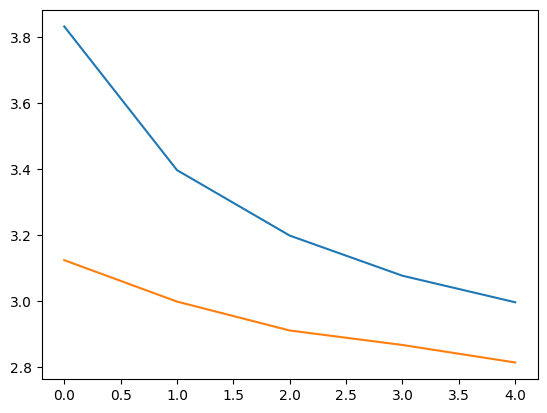

In [218]:
plt.plot(np.arange(len(history['train_loss'])), history['train_loss'])
plt.plot(np.arange(len(history['val_loss'])), history['val_loss'])

In [ ]:
history = fit(model, optimizer, train_dataloader, val_dataloader, epochs=5, device=device)

In [5]:
model = SSD300(n_classes=6).to(device)
model.load_state_dict(torch.load('/kaggle/input/ssd300-helmets/ssd300_helmets.pt'))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 59.1MB/s] 



Loaded base model.



<All keys matched successfully>

Код для вычисления mean average precision

In [21]:
def get_mAP(dataset, model):
    '''Подсчитывает статистики Mean Average Precision для model на dataset'''
    metric = MeanAveragePrecision(iou_type="bbox")
    for i in range(len(dataset)):
        image = dataset[i][0]
        gt_locs = dataset[i][1]
        gt_classes = dataset[i][2]
        gt_locs = torch.tensor(gt_locs).to(device)
        gt_classes = torch.tensor(gt_classes).to(device)
        pred = {}
        target = {}
        target['boxes'] = gt_locs.detach().cpu()
        target['labels'] = gt_classes.detach().cpu()
        
        locs, class_scores = model(image.unsqueeze(0).to(device))
        locs, labels, scores = model.detect_objects(locs, class_scores, min_score=0.2, max_overlap=0.2, top_k=20)
        pred['boxes'] = locs[0].detach().cpu()
        pred['labels'] = labels[0].detach().cpu()
        pred['scores'] = scores[0].detach().cpu()
        
        metric.update([pred], [target])
    return metric.compute()

Ниже обучили еще 15 эпох модели. Посмотрим на визуализацию предсказаний. Синий -- ground truth, красный -- предсказание. 0 класс -- бэкграунд. У обученной модели низкий confidence: для генерации используется порог скора 0.2, для больших порогов боксы просто не предсказываются. Это не очень хорошо

[tensor([0.6363, 0.3638, 0.3267, 0.3178], device='cuda:0')]
[tensor([0.3224, 0.2462, 0.2369], device='cuda:0')]
[tensor([0.5854, 0.5286, 0.5176, 0.4645, 0.4579, 0.4284, 0.4202, 0.3343, 0.3052,
        0.3045, 0.2990, 0.2980, 0.2770, 0.2447, 0.2447, 0.2027],
       device='cuda:0')]
[tensor([0.7837, 0.4942, 0.3072], device='cuda:0')]
[tensor([0.5625, 0.4333, 0.4067, 0.2820, 0.2730, 0.2663, 0.2468, 0.2383, 0.2230],
       device='cuda:0')]
[tensor([0.5471, 0.4798, 0.3865], device='cuda:0')]
[tensor([0.2924], device='cuda:0')]
[tensor([0.9672, 0.9142, 0.6942, 0.3866, 0.2951], device='cuda:0')]
[tensor([0.9439], device='cuda:0')]


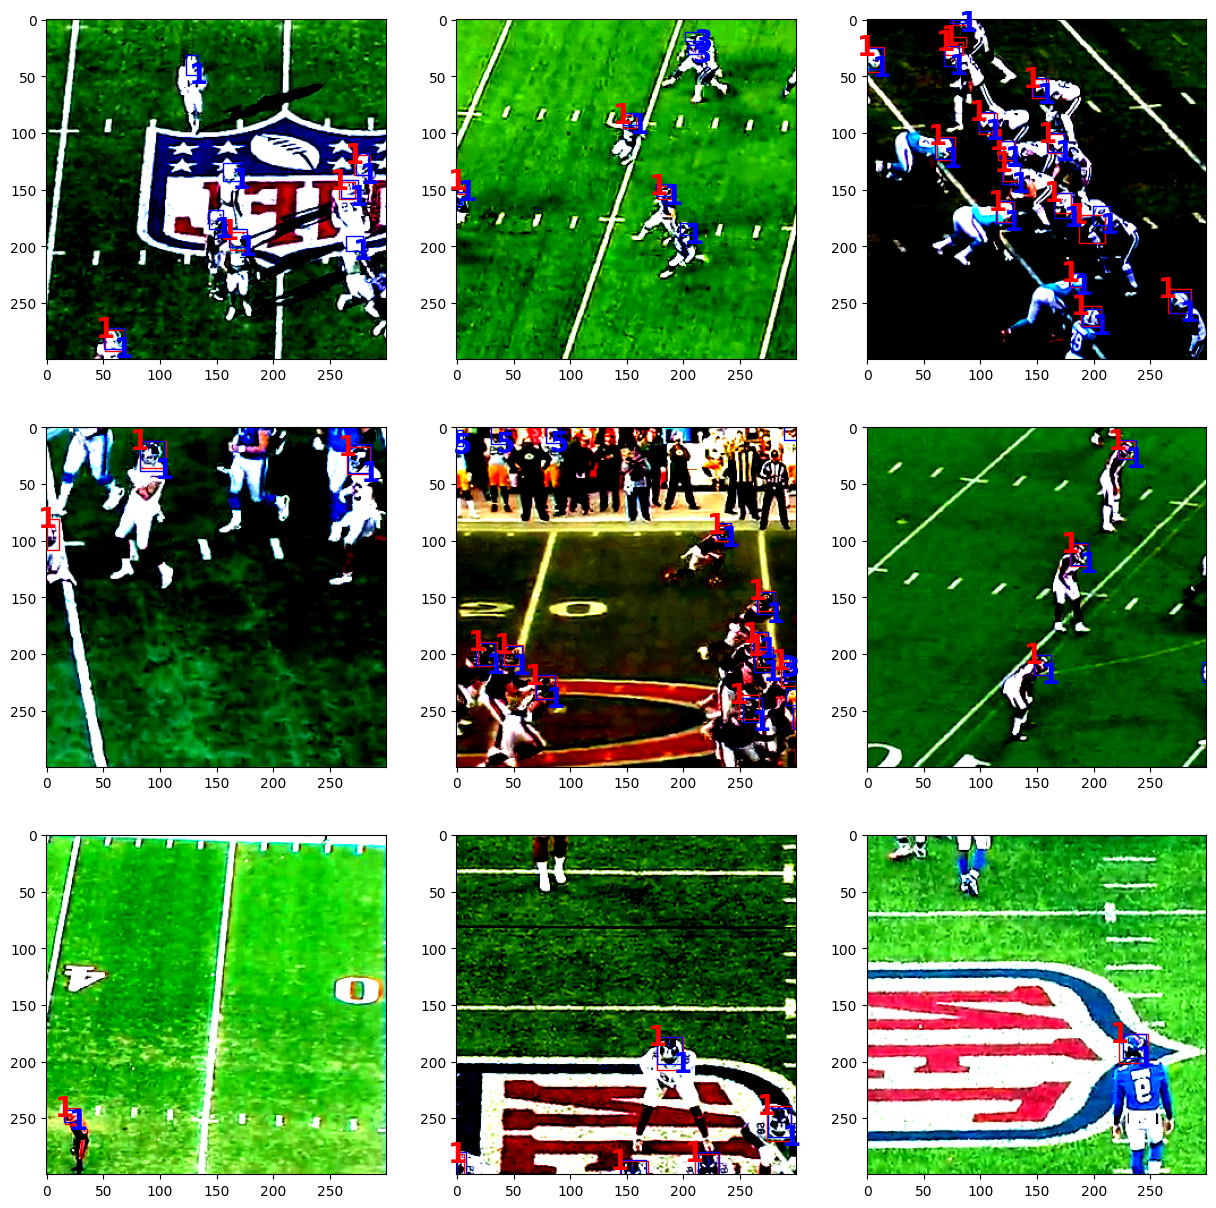

In [80]:
colors = ['red', 'magenta', 'yellow', 'cyan']

with torch.no_grad():
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
    idxs = np.random.randint(0, len(val_dataset), size=9)
    for en, idx in enumerate(idxs):
        img, boxes, labels = train_dataset[idx]
        boxes_pr, labels_pr = model(img[None, :].to(device))
        boxes_pr, labels_pr, scores_pr = model.detect_objects(boxes_pr, labels_pr, min_score=0.2, max_overlap=0.2, top_k=20)
        print(scores_pr)
        ax = axes[en // 3, en % 3]
        ax.imshow(img.movedim(0, 2))

        for i, box in enumerate(boxes_pr[0]):
            box = box.cpu()
            rect = Rectangle((box[0] * 300, box[1] * 300), (box[2]-box[0]) * 300, (box[3]-box[1]) * 300, 
                         linewidth=1,edgecolor='red',
                         facecolor='none')
            ax.annotate(labels_pr[0][i].item(), (box[0] * 300, box[1] * 300), color='red', weight='bold', fontsize=20, ha='center', va='center')
            ax.add_patch(rect)

        for i, box in enumerate(boxes):
            rect = Rectangle((box[0] * 300, box[1] * 300), (box[2]-box[0]) * 300, (box[3]-box[1]) * 300, 
                         linewidth=1,edgecolor='blue',
                         facecolor='none')
            ax.annotate(labels[i].item(), (box[2] * 300, box[3] * 300), color='blue', weight='bold', fontsize=20, ha='center', va='center')
            ax.add_patch(rect)

Видно, что модель хорошо предсказывает боксы. Все предсказанные классы 1: просто Helmet, этот класс чаще других встречается. Возможно, стоит перевзвесить классы в кросс-энтропии, либо просто обучаться еще больше, все-таки у модели нет огромного конфиденса в пользу 1 класса, они все довольно низкие.

Посчитаем mean average precision на валидационной выборке.

In [199]:
map_score = get_mAP(val_dataset, model)
map_score

{'map': tensor(0.0726),
 'map_50': tensor(0.1435),
 'map_75': tensor(0.0681),
 'map_small': tensor(0.0726),
 'map_medium': tensor(-1.),
 'map_large': tensor(-1.),
 'mar_1': tensor(0.0370),
 'mar_10': tensor(0.0975),
 'mar_100': tensor(0.0986),
 'mar_small': tensor(0.0986),
 'mar_medium': tensor(-1.),
 'mar_large': tensor(-1.),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor([0, 1, 2, 3, 4, 5], dtype=torch.int32)}

map_50 получился 17.5%. Не очень много, у модели с соревнования было 35%. Очевидно, mAP проседает из-за остальных классов, потому что Helmet неплохо предсказывается.

In [56]:
torch.save(model.state_dict(), '/kaggle/working/ssd300_helmets.pt')
torch.save(optimizer.state_dict(), '/kaggle/working/ssd300_helmets_opt.pt')

In [35]:
optimizer = torch.optim.Adam(model.parameters())
optimizer.load_state_dict(torch.load('/kaggle/input/ssd300-helmets/ssd300_helmets_opt.pt'))

Еще 15 эпох обучения

In [37]:
history = fit(model, optimizer, train_dataloader, val_dataloader, epochs=15)

100%|██████████| 15/15 [2:14:27<00:00, 537.81s/it]

Epoch 14
train_loss: 2.4121
val_loss: 2.4436


График лосса

Text(0.5, 0, 'epoch')

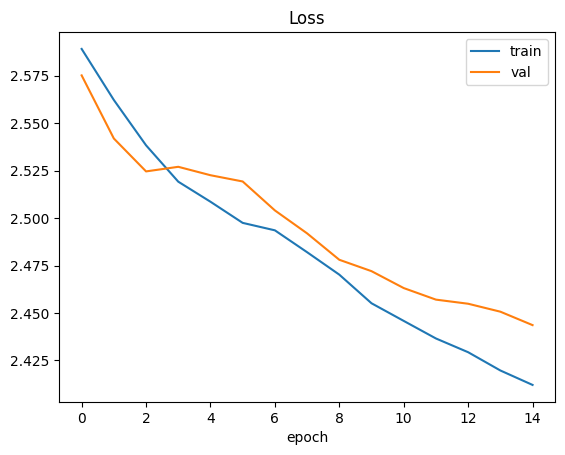

In [55]:
plt.plot(np.arange(len(history['train_loss'])), history['train_loss'], label='train')
plt.plot(np.arange(len(history['val_loss'])), history['val_loss'], label='val')
plt.legend()
plt.title('Loss')
plt.xlabel('epoch')

Функция для инференса скользящим окном

In [7]:
def sw_inference(model, batch, patch_size, overlap, device):
    _, _,H, W = batch.shape    
    patch_H, patch_W = patch_size
    
    padding_H = int(patch_H * (1-overlap) - H % (patch_H * (1-overlap)))
    padding_W = int(patch_W * (1-overlap) - W % (patch_H * (1-overlap)))
    
    padded_batch = F.pad(batch, (0, padding_W, 0, padding_H))
    N, C, H, W = batch.shape
    patches = []
    left = []
    for w in np.arange(0, W, patch_W * (1-overlap)).astype('int')[:-1]:
        for h in np.arange(0, H, patch_H * (1-overlap)).astype('int')[:-1]:
            patches.append(padded_batch[..., h:h+patch_H, w:w+patch_W])
            left.append((h, w))
    patches = torch.cat(patches, dim=0)
    boxes_pr, labels_pr = model(patches.to(device))
    boxes_pr, labels_pr, scores_pr = model.detect_objects(boxes_pr, labels_pr, min_score=0.15, max_overlap=0.2, top_k=20)
                         
    return boxes_pr, labels_pr, left, patches

In [95]:
%cd /kaggle/working
!mkdir test

/kaggle/working


In [96]:
test_files = [x for x in (comp_root / 'test').iterdir()]
for file in test_files:
    vidc = cv2.VideoCapture(str(file))
    fpref = file.name.rstrip('.mp4')    
    success = True
    n_frame = 1
    while success:
        success, fr = vidc.read()
        if success:
            cv2.imwrite(str(work_root / 'test' / str(fpref + f'_{n_frame}.jpg')), fr)
        n_frame += 1

In [97]:
annot_test = pd.read_csv(comp_root / 'test_baseline_helmets.csv')
annot_test.head()
annot_test['image'] = annot_test['video_frame'].apply(lambda x : x + '.jpg')
annot_test.drop(columns='video_frame', inplace=True)
annot_test['label_enc'] = [0] * len(annot_test)
annot_test.drop(index=annot_test[annot_test.height == 0].index, inplace=True)
annot_test.head()

left  width  top  height      conf                        image  label_enc
0   402     18  418      20  0.488037  58102_002798_Sideline_1.jpg          0
1   373     21  430      23  0.748047  58102_002798_Sideline_1.jpg          0
2   711     20  405      21  0.827148  58102_002798_Sideline_1.jpg          0
3   392     21  452      22  0.829590  58102_002798_Sideline_1.jpg          0
4   457     19  366      23  0.837402  58102_002798_Sideline_1.jpg          0

In [11]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

transforms = A.Compose([
    A.Normalize(mean=MEAN, std=STD),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.2),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

test_dataset = HelmetDataset(work_root / 'test', annot_test, transforms)

In [100]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# transforms = A.Compose([
#     A.Normalize(mean=MEAN, std=STD),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.2),
#     ToTensorV2()
# ], bbox_params=A.BboxParams(format='coco', label_fields=['labels']))

test_dataset = HelmetDataset(work_root / 'test', annot_test)

In [101]:
%cd /kaggle/working
!mkdir test_predictions

/kaggle/working


In [111]:
for qq in tqdm(range(len(test_dataset))): #
    image = test_dataset[qq]
    fig = plt.figure(figsize=(7, 12.8))
    ax = plt.gca()
    
    with torch.no_grad():
        output = model(torch.tensor(img_proc(image[0]).pixel_values).to('cuda'))

    ax.imshow(image[0] / 256)
    height, width, _ = image[0].shape
    output = img_proc.post_process_object_detection(output, threshold=0.5, target_sizes=([[height, width]]))[0]
    output = non_max_suppression(output)

    labels_pr = output['labels']
    for i in range(len(labels_pr)):
        box = output['boxes'].cpu().squeeze()[i]
        rect = Rectangle(((box[0]), (box[1])), (box[2]-box[0]), (box[3]-box[1]),
                         linewidth=1, 
                         edgecolor='red',
                         facecolor='none')
        ax.annotate(labels_pr[i].item(), (box[0], box[1]), color='red', weight='bold', fontsize=20, ha='center', va='center')
        ax.add_patch(rect)
        
    plt.axis('off')
    plt.savefig(work_root / f'test_predictions/testframe{qq}.jpg')
    fig.clf()
    plt.close()
    gc.collect()

100%|██████████| 2664/2664 [1:31:51<00:00,  2.07s/it]


  2%|▏         | 61/2664 [00:49<35:23,  1.23it/s]Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7e7e6d644c10>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/matplotlib/transforms.py", line 209, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id(self): pop(k))
KeyboardInterrupt: 
  4%|▍         | 103/2664 [01:25<35:32,  1.20it/s]


KeyboardInterrupt: 

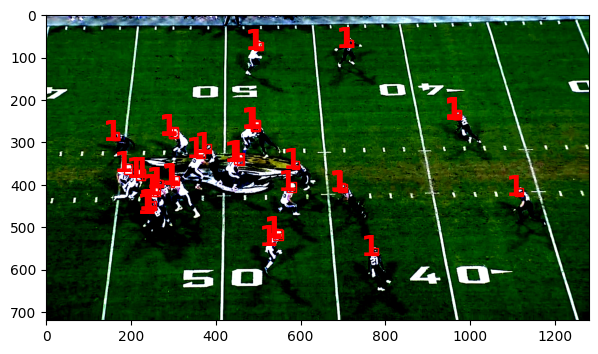

In [19]:
for qq in tqdm(range(len(test_dataset))):
    image = test_dataset[qq]
    boxes_pr, labels_pr, left, patches = sw_inference(model, image[0][None, :], (300, 300), 0.25, device)
    fig = plt.figure(figsize=(7, 12.8))
    ax = plt.gca()
    with torch.no_grad():
        for Зj in range(len(left)):
            for i, box in enumerate(boxes_pr[j]):
                box = box.cpu()
                if labels_pr[j][i] == 0:
                    continue
                rect = Rectangle((left[j][1]+box[0] * 300,left[j][0]+box[1] * 300), (box[2]-box[0]) * 300, (box[3]-box[1]) * 300, 
                             linewidth=1,edgecolor='red',
                             facecolor='none')
                ax.annotate(labels_pr[j][i].item(), (left[j][1]+box[0] * 300, left[j][0]+box[1] * 300), color='red', weight='bold', fontsize=20, ha='center', va='center')
                ax.add_patch(rect)
    #             rect = Rectangle((left[j][1], left[j][0]), 300, 300, 
    #                          linewidth=1,edgecolor='blue',
    #                          facecolor='none')
    #             ax.add_patch(rect)
    #             plt.imshow(test_dataset[0][0][..., left[j][1]:left[j][1]+300, left[j][0]:left[j][0]+300].movedim(0, 2))
        
        plt.imshow(image[0].movedim(0, 2))
        plt.savefig(work_root / f'test_predictions/testframe{qq}.jpg')
        fig.clf()
        plt.close()
        gc.collect()

Прогнали SSD по всем патчам с картинки  получили предикт

In [113]:
pred_imgs = []
for i in range(2664):
    pred_imgs.append(cv2.imread(str(work_root / f'test_predictions/testframe{i}.jpg')))
    
height, width, layers = pred_imgs[0].shape   
out = cv2.VideoWriter(str(work_root / 'test.mp4'),cv2.VideoWriter_fourcc(*"mp4v"), 20, (width, height))
for i in range(len(pred_imgs)):
    out.write(pred_imgs[i])
out.release()

Здесь записали видео из предсказаний по кадрам.